Installation

In [2]:
!pip install torch==2.0.1 torchtext==0.15.2

  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchtext-0.15.2-cp310-cp310-manylinux1_x86_64.whl.metadata (7.4 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.0 kB)
  Using cached torchdata-0.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
Using cached torchtext-0.15.2-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
Using cached torchdata-0.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
     

In [3]:
!pip install datasets

Import statements

In [4]:
import torchtext
import string
import nltk
import re
import html
import random
import subprocess
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
import zipfile
import os
import math
from random import shuffle
import numpy as np

In [5]:
def split_dataset(file_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    sentences = []
    
    with open(file_path, 'r') as f:
        para = ""
        for line in tqdm(f, desc="Splitting dataset"):
            if line.strip():
                para += line.strip() + " "
            else:
                if para:
                    sentences.extend(sent_tokenize(para))
                    para = ""
        if para:
            sentences.extend(sent_tokenize(para))

    shuffle(sentences)

    total_sentences = len(sentences)
    train_size = int(total_sentences * train_ratio)
    val_size = int(total_sentences * val_ratio)
    
    train_sentences = sentences[:train_size]
    val_sentences = sentences[train_size:train_size + val_size]
    test_sentences = sentences[train_size + val_size:]

    return train_sentences, val_sentences, test_sentences

In [6]:
def save_datasets(train_sentences, val_sentences, test_sentences):
    with open('train.txt', 'w') as f:
        f.writelines([s + '\n' for s in train_sentences])
    with open('dev.txt', 'w') as f:
        f.writelines([s + '\n' for s in val_sentences])
    with open('test.txt', 'w') as f:
        f.writelines([s + '\n' for s in test_sentences])

In [7]:
train_sentences, val_sentences, test_sentences = split_dataset('/kaggle/input/auguste-maquet/Auguste_Maquet.txt')
save_datasets(train_sentences, val_sentences, test_sentences)

Splitting dataset: 128612it [00:02, 45509.61it/s]


In [8]:
def get_embeddings(emb_file='glove.6B.300d.txt'):
    unk_emb = torch.zeros(300) 
    embeddings = defaultdict(lambda: unk_emb)

    with open(emb_file, 'r', encoding='ISO-8859-1') as f:
        for line in tqdm(f, desc="Reading embeddings"):
            try:
                split = line.strip().split()
                word = split[0]
                vector = torch.tensor([float(x) for x in split[1:]])
                embeddings[word] = vector
            except ValueError as e:
                continue

    return embeddings

In [9]:
embeddings = get_embeddings('/kaggle/input/glove/pytorch/default/1/glove.6B.300d.txt')

Reading embeddings: 400000it [01:15, 5294.38it/s]


In [10]:
class TextData(Dataset):
    def __init__(self, file_path='train.txt', pretrained_emb_dict=embeddings,
                 frequency_cutoff=1, context_size=5, vocab=None):
        self.file_path = file_path
        self.frequency_cutoff = frequency_cutoff
        self.context_size = context_size

        self.contexts = []
        self.words = []

        self.frequency_dictionary = defaultdict(lambda: 0)
        self.vocab = vocab if vocab else []

        self.words2indices = {}
        self.embeddings = pretrained_emb_dict

        with open(self.file_path, 'r') as f:
            for line in tqdm(f, desc="Obtaining vocabulary and freq counts"):
                words = [word.lower() for word in word_tokenize(line)]
                if not vocab:
                    self.vocab += words
                for word in words:
                    self.frequency_dictionary[word] += 1

            if not vocab:
                self.vocab = list(set(self.vocab))
                self.vocab = [word for word in self.vocab if self.frequency_dictionary[word] > self.frequency_cutoff]
                self.vocab.append('<unk>')
            self.words2indices = {w: i for i, w in enumerate(self.vocab)}

        embeddings_list = []
        for word in self.vocab:
            embeddings_list.append(self.embeddings[word])
        embeddings_list.append(self.embeddings['<unk>'])
        self.embeddings = torch.stack(embeddings_list)

        with open(self.file_path, 'r') as f:
            for line in tqdm(f, desc="Creating dataset"):
                words = [word.lower() for word in word_tokenize(line)]
                indices = [self.words2indices[word] if word in self.vocab else (len(self.vocab) - 1)
                           for word in words]
                embeddings = [self.embeddings[i] for i in indices]

                for i in range(len(embeddings) - self.context_size):
                    self.contexts.append(torch.stack(embeddings[i:i + self.context_size]))
                    self.words.append(indices[i + self.context_size])

        self.contexts = torch.stack(self.contexts)
        self.words = torch.tensor(self.words)

    def __getitem__(self, idx):
        return (self.contexts[idx], self.words[idx])

    def __len__(self):
        return len(self.contexts)

In [11]:
train_ds = TextData()
with open('vocab.txt', 'w') as f:
    for word in train_ds.vocab:
        f.write(word + '\n')

test_ds = TextData('test.txt', vocab=train_ds.vocab)
dev_ds = TextData('dev.txt', vocab=train_ds.vocab)

Obtaining vocabulary and freq counts: 39555it [00:09, 4047.88it/s]
Creating dataset: 39555it [01:58, 333.35it/s]
Obtaining vocabulary and freq counts: 5652it [00:01, 4214.45it/s]
Creating dataset: 5652it [00:16, 349.03it/s]
Obtaining vocabulary and freq counts: 11301it [00:02, 4060.74it/s]
Creating dataset: 11301it [00:33, 339.53it/s]


In [12]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, context_size=5,
                 hidden_size_1=300, hidden_size_2=300, dropout_rate=0.0):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=300 * context_size, out_features=hidden_size_1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        self.output = nn.Linear(in_features=hidden_size_2, out_features=vocab_size)

    def forward(self, batch_ctx):
        batch_ctx = batch_ctx.flatten(1, 2)
        logits = self.fc1(batch_ctx)
        logits = self.fc2(logits)
        logits = self.output(logits)
        return logits
    
    def train_epoch(self, dl, optimiser, loss_fn):
        for batch in tqdm(dl):
            optimiser.zero_grad()
            contexts, words = batch
            logits = self.forward(contexts)
            loss = loss_fn(logits, words)
            loss.backward()
            optimiser.step()

    def train_model(self, num_epochs, lr, train_dl, dev_dl, optimiser_type='SGD'):
        if optimiser_type == 'SGD':
            optimiser = torch.optim.SGD(self.parameters(), lr=lr)
        elif optimiser_type == 'Adam':
            optimiser = torch.optim.Adam(self.parameters(), lr=lr)

        loss_fn = nn.CrossEntropyLoss()

        train_perplexities, val_perplexities = [], []
        for epoch in range(num_epochs):
            self.train_epoch(train_dl, optimiser, loss_fn)
            train_perp = self.get_perp(train_dl)
            val_perp = self.get_perp(dev_dl)

            print(f"Epoch {epoch+1} - Train perplexity: {train_perp:.4f}, Validation perplexity: {val_perp:.4f}")
            train_perplexities.append(train_perp)
            val_perplexities.append(val_perp)

        return train_perplexities, val_perplexities

    def get_loss(self, dl, loss_fn):
        total_loss = 0
        total_samples = 0

        for batch in tqdm(dl):
            contexts, words = batch
            pred = self.forward(contexts)
            loss = loss_fn(pred, words)
            total_loss += loss.item() * len(words)
            total_samples += len(words)

        avg_loss = total_loss / total_samples
        return avg_loss

    def get_perp(self, dl, filename='perplexity_output.txt'):
        total_loss = 0
        total_samples = 0
        loss_fn = nn.CrossEntropyLoss(reduction='sum')
        self.eval()

        sentence_perplexities = []
        with open(filename, 'w') as f, torch.no_grad():
            for batch in tqdm(dl):
                contexts, words = batch

                # Forward pass
                pred = self.forward(contexts)

                # Calculate loss for the batch
                loss = loss_fn(pred, words)
                
                # Calculate perplexity for the batch
                perplexity = torch.exp(loss / len(words))

                # Format the contexts (as a sentence) and their corresponding perplexity
                sentence = ' '.join([train_ds.vocab[idx] for idx in words.tolist()])
                f.write(f"{sentence}\t{perplexity.item()}\n")
                
                total_loss += loss.item()
                total_samples += len(words)

                sentence_perplexities.append(perplexity.item())

            avg_loss = total_loss / total_samples
            avg_perplexity = math.exp(avg_loss)

            f.write(f"Average perplexity: {avg_perplexity}\n")
            print(f"Average perplexity: {avg_perplexity}")

        return avg_perplexity

In [12]:
lm = LanguageModel(len(train_ds.vocab))
lm.train(5)

torch.save(lm, '5epochs.pth')

perp = lm.get_perp(test_dl)
print(perp)

epoch:  1


100%|██████████| 5017/5017 [00:50<00:00, 100.25it/s]


Loss on train set: 5.8628123491625965


100%|██████████| 1424/1424 [00:13<00:00, 102.60it/s]


Loss on validation set: 5.813640917668998


100%|██████████| 5017/5017 [00:51<00:00, 97.79it/s] 


Perplexity on train set: 351.7118910664069


100%|██████████| 1424/1424 [00:14<00:00, 97.34it/s] 


Perplexity on validation set: 334.8360194046033
epoch:  2


100%|██████████| 5017/5017 [00:48<00:00, 103.31it/s]


Loss on train set: 5.585124443335411


100%|██████████| 1424/1424 [00:13<00:00, 104.28it/s]


Loss on validation set: 5.5357256856912835


100%|██████████| 5017/5017 [00:50<00:00, 98.69it/s] 


Perplexity on train set: 266.4334365420458


100%|██████████| 1424/1424 [00:14<00:00, 96.18it/s]


Perplexity on validation set: 253.59174878354986
epoch:  3


100%|██████████| 5017/5017 [00:48<00:00, 102.82it/s]


Loss on train set: 5.419975726109035


100%|██████████| 1424/1424 [00:13<00:00, 103.40it/s]


Loss on validation set: 5.37387692020511


100%|██████████| 5017/5017 [00:52<00:00, 96.20it/s] 


Perplexity on train set: 225.87363960338834


100%|██████████| 1424/1424 [00:14<00:00, 96.68it/s]


Perplexity on validation set: 215.69749073551233
epoch:  4


100%|██████████| 5017/5017 [00:50<00:00, 99.47it/s] 


Loss on train set: 5.296004307012548


100%|██████████| 1424/1424 [00:14<00:00, 98.94it/s] 


Loss on validation set: 5.2548997459317395


100%|██████████| 5017/5017 [00:53<00:00, 93.89it/s] 


Perplexity on train set: 199.53792270506767


100%|██████████| 1424/1424 [00:14<00:00, 97.21it/s]


Perplexity on validation set: 191.5022860087083
epoch:  5


100%|██████████| 5017/5017 [00:50<00:00, 99.33it/s] 


Loss on train set: 5.201346799808551


100%|██████████| 1424/1424 [00:14<00:00, 98.89it/s] 


Loss on validation set: 5.1652361452168885


100%|██████████| 5017/5017 [00:51<00:00, 96.91it/s] 


Perplexity on train set: 181.51654377175038


100%|██████████| 1424/1424 [00:14<00:00, 96.32it/s]


Perplexity on validation set: 175.0787977112436


100%|██████████| 722/722 [00:07<00:00, 94.91it/s]

178.35956930515505


In [18]:
test_dl = DataLoader(test_ds, batch_size=128)

In [27]:
def experiment(train_ds, dev_ds, test_ds, vocab_size):
    train_dl = DataLoader(train_ds, batch_size=128)
    dev_dl = DataLoader(dev_ds, batch_size=128)
    test_dl = DataLoader(test_ds, batch_size=128)

    hyperparams = [
        {'lr': 0.01, 'hidden_size_1': 300, 'hidden_size_2': 300, 'dropout_rate': 0.2, 'optim': 'SGD'},
        {'lr': 0.001, 'hidden_size_1': 400, 'hidden_size_2': 300, 'dropout_rate': 0.3, 'optim': 'Adam'},
        {'lr': 0.01, 'hidden_size_1': 500, 'hidden_size_2': 500, 'dropout_rate': 0.1, 'optim': 'SGD'}
    ]

    train_perplexities, dev_perplexities, test_perplexities = [], [], []

    for params in hyperparams:
        model = LanguageModel(vocab_size, hidden_size_1=params['hidden_size_1'],
                              hidden_size_2=params['hidden_size_2'],
                              dropout_rate=params['dropout_rate'])
        
        print(f"Training with hyperparams: {params}")
        train_perp, val_perp = model.train(num_epochs=5, lr=params['lr'],
                                           train_dl=train_dl, dev_dl=dev_dl,
                                           optimiser_type=params['optim'])

        train_perplexities.append(train_perp)
        dev_perplexities.append(val_perp)
        
        test_perp = model.get_perp(test_dl)
        test_perplexities.append(test_perp)
        print(f"Test perplexity: {test_perp:.4f}")

    return hyperparams, train_perplexities, dev_perplexities, test_perplexities


In [24]:
def plot_perplexity_results(hyperparams, train_perplexities, dev_perplexities, test_perplexities):
    plt.figure(figsize=(15, 9)) 

    epochs = list(range(1, 6)) 

    for i, params in enumerate(hyperparams):
        
        plt.plot(epochs, train_perplexities[i], label=f"Train - {params}")
        plt.plot(epochs, dev_perplexities[i], label=f"Dev - {params}")

        plt.plot([5], [test_perplexities[i]], 'o', label=f"Test - {params}")

    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title('Train, Dev, and Test Perplexity Over Epochs')
    
    plt.legend(loc='best')  
    plt.tight_layout()     

    plt.show()

Training with hyperparams: {'lr': 0.01, 'hidden_size_1': 300, 'hidden_size_2': 300, 'dropout_rate': 0.2, 'optim': 'SGD'}


100%|██████████| 1424/1424 [00:14<00:00, 99.55it/s] 


Epoch 1 - Train perplexity: 389.6638, Validation perplexity: 373.0976


100%|██████████| 1424/1424 [00:15<00:00, 94.42it/s]


Epoch 2 - Train perplexity: 296.3731, Validation perplexity: 284.3721


100%|██████████| 1424/1424 [00:15<00:00, 93.13it/s] 


Epoch 3 - Train perplexity: 254.5791, Validation perplexity: 244.7412


100%|██████████| 1424/1424 [00:15<00:00, 93.98it/s]


Epoch 4 - Train perplexity: 226.7140, Validation perplexity: 218.3448


100%|██████████| 1424/1424 [00:15<00:00, 94.15it/s]


Epoch 5 - Train perplexity: 206.7533, Validation perplexity: 199.9157


100%|██████████| 715/715 [00:08<00:00, 87.05it/s]


Test perplexity: 201.5020
Training with hyperparams: {'lr': 0.001, 'hidden_size_1': 400, 'hidden_size_2': 300, 'dropout_rate': 0.3, 'optim': 'Adam'}


100%|██████████| 1424/1424 [00:15<00:00, 89.96it/s]


Epoch 1 - Train perplexity: 144.4859, Validation perplexity: 154.1624


100%|██████████| 1424/1424 [00:15<00:00, 94.52it/s] 


Epoch 2 - Train perplexity: 123.5464, Validation perplexity: 146.1823


100%|██████████| 1424/1424 [00:15<00:00, 93.00it/s]


Epoch 3 - Train perplexity: 116.2894, Validation perplexity: 152.6047


100%|██████████| 1424/1424 [00:14<00:00, 96.12it/s]


Epoch 4 - Train perplexity: 111.2767, Validation perplexity: 158.1336


100%|██████████| 1424/1424 [00:15<00:00, 89.92it/s]


Epoch 5 - Train perplexity: 111.0479, Validation perplexity: 169.5196


100%|██████████| 715/715 [00:07<00:00, 94.69it/s]


Test perplexity: 167.8153
Training with hyperparams: {'lr': 0.01, 'hidden_size_1': 500, 'hidden_size_2': 500, 'dropout_rate': 0.1, 'optim': 'SGD'}


100%|██████████| 1424/1424 [00:21<00:00, 67.70it/s]


Epoch 1 - Train perplexity: 358.1415, Validation perplexity: 343.0785


100%|██████████| 1424/1424 [00:20<00:00, 70.69it/s]


Epoch 2 - Train perplexity: 274.2912, Validation perplexity: 263.1736


100%|██████████| 1424/1424 [00:20<00:00, 70.38it/s]


Epoch 3 - Train perplexity: 234.2310, Validation perplexity: 225.3139


100%|██████████| 1424/1424 [00:20<00:00, 68.79it/s]


Epoch 4 - Train perplexity: 206.7796, Validation perplexity: 200.1598


100%|██████████| 1424/1424 [00:20<00:00, 68.14it/s]


Epoch 5 - Train perplexity: 188.6581, Validation perplexity: 183.1115


100%|██████████| 715/715 [00:10<00:00, 69.93it/s]


Test perplexity: 183.8799


TypeError: object of type 'float' has no len()

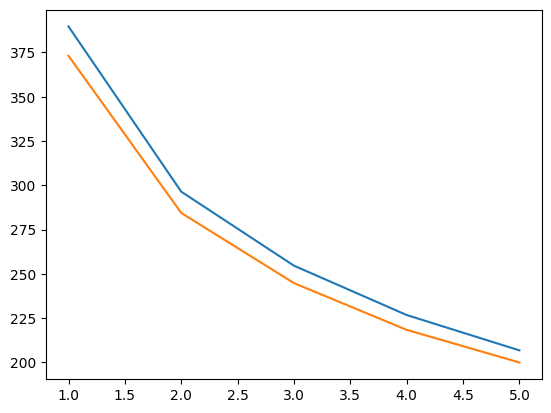

In [24]:
hyperparams, train_perplexities, dev_perplexities, test_perplexities = experiment(train_ds, dev_ds, test_ds, vocab_size)

In [ ]:
plot_perplexity_results(hyperparams, train_perplexities, dev_perplexities, test_perplexities)

In [16]:
# Hyperparameters used in the experiment
hyperparams = [
    {'lr': 0.01, 'hidden_size_1': 300, 'hidden_size_2': 300, 'dropout_rate': 0.2, 'optim': 'SGD'},
    {'lr': 0.001, 'hidden_size_1': 400, 'hidden_size_2': 300, 'dropout_rate': 0.3, 'optim': 'Adam'},
    {'lr': 0.01, 'hidden_size_1': 500, 'hidden_size_2': 500, 'dropout_rate': 0.1, 'optim': 'SGD'}
]

# Manually creating lists from printed perplexities
train_perplexities = [
    [389.6638, 296.3731, 254.5791, 226.7140, 206.7533],  # For first set of hyperparams
    [144.4859, 123.5464, 116.2894, 111.2767, 111.0479],  # For second set of hyperparams
    [358.1415, 274.2912, 234.2310, 206.7796, 188.6581]   # For third set of hyperparams
]

dev_perplexities = [
    [373.0976, 284.3721, 244.7412, 218.3448, 199.9157],  # For first set of hyperparams
    [154.1624, 146.1823, 152.6047, 158.1336, 169.5196],  # For second set of hyperparams
    [343.0785, 263.1736, 225.3139, 200.1598, 183.1115]   # For third set of hyperparams
]

# Test perplexities are single values, so we'll use a list with one value for each hyperparam set
test_perplexities = [201.5020, 167.8153, 183.8799]


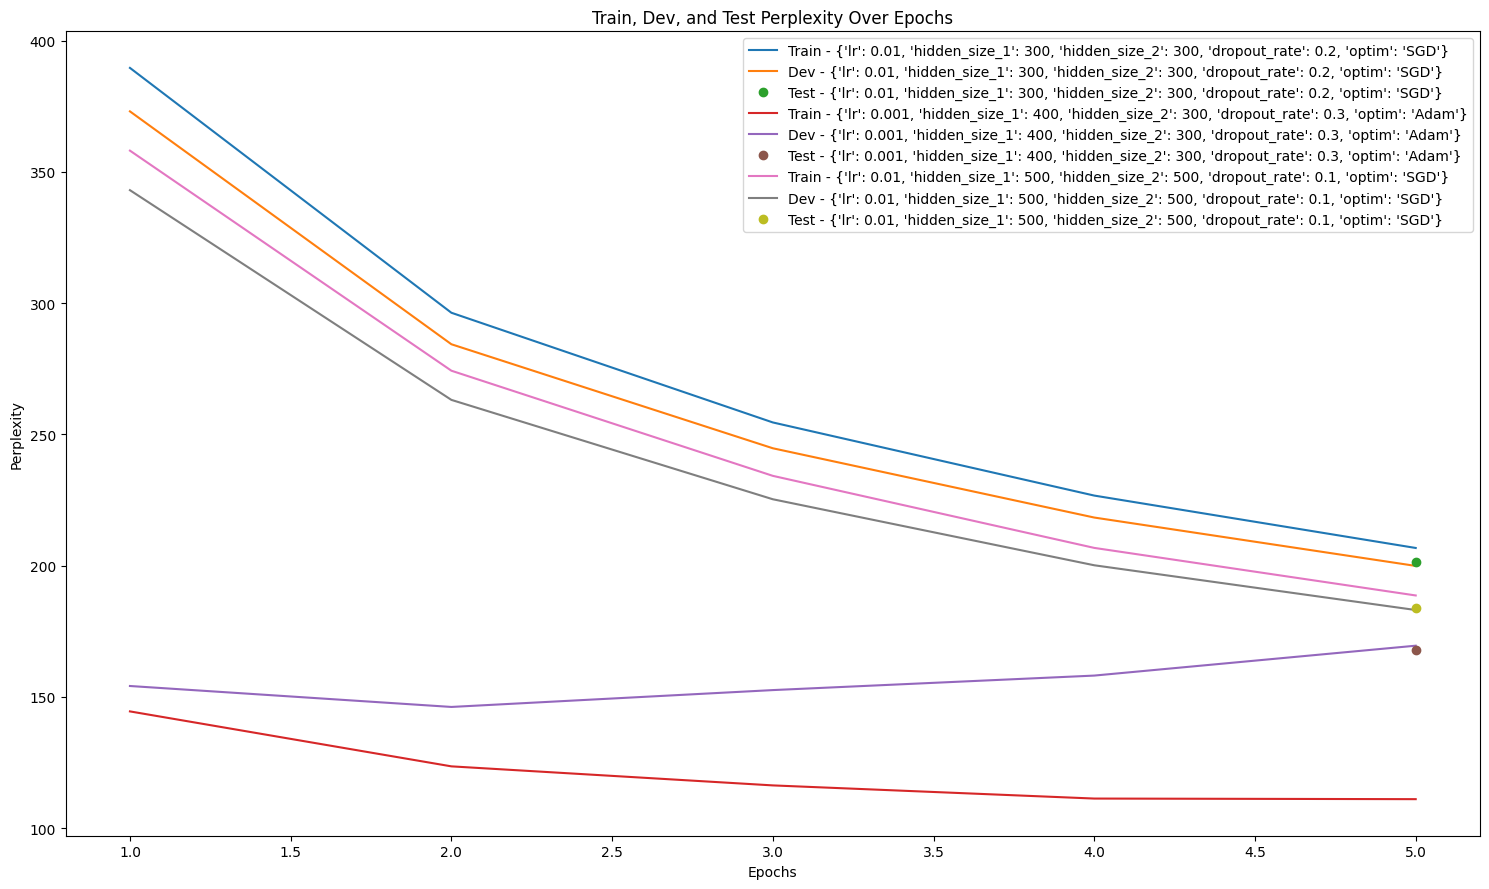

In [25]:
plot_perplexity_results(hyperparams, train_perplexities, dev_perplexities, test_perplexities)

In [13]:
model = LanguageModel(vocab_size=len(train_ds.vocab))
train_dl = DataLoader(train_ds, batch_size=128)
dev_dl = DataLoader(dev_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=128)

train_perplexities, val_perplexities = model.train_model(
    num_epochs=10, 
    lr=0.1, 
    train_dl=train_dl, 
    dev_dl=dev_dl
)

model.get_perp(train_dl, filename='train_perplexity.txt')
model.get_perp(test_dl, filename='test_perplexity.txt')
print("Perplexity files generated for both train and test sets.")

100%|██████████| 5031/5031 [00:45<00:00, 110.91it/s]


Average perplexity: 154.6741814092297


100%|██████████| 1426/1426 [00:12<00:00, 112.55it/s]


Average perplexity: 151.06318422594805
Epoch 1 - Train perplexity: 154.6742, Validation perplexity: 151.0632


100%|██████████| 5031/5031 [00:44<00:00, 111.94it/s]


Average perplexity: 117.85714270126645


100%|██████████| 1426/1426 [00:12<00:00, 117.06it/s]


Average perplexity: 119.75482211061586
Epoch 2 - Train perplexity: 117.8571, Validation perplexity: 119.7548


100%|██████████| 5031/5031 [00:45<00:00, 110.53it/s]


Average perplexity: 100.96291308130792


100%|██████████| 1426/1426 [00:13<00:00, 104.25it/s]


Average perplexity: 106.93744066891945
Epoch 3 - Train perplexity: 100.9629, Validation perplexity: 106.9374


100%|██████████| 5031/5031 [00:42<00:00, 119.30it/s]


Average perplexity: 90.5613347374721


100%|██████████| 1426/1426 [00:11<00:00, 120.79it/s]


Average perplexity: 100.21899299080442
Epoch 4 - Train perplexity: 90.5613, Validation perplexity: 100.2190


100%|██████████| 5031/5031 [00:45<00:00, 110.97it/s]


Average perplexity: 82.90918978200784


100%|██████████| 1426/1426 [00:13<00:00, 101.86it/s]


Average perplexity: 96.09526329955037
Epoch 5 - Train perplexity: 82.9092, Validation perplexity: 96.0953


100%|██████████| 5031/5031 [00:42<00:00, 119.21it/s]


Average perplexity: 76.43475199270559


100%|██████████| 1426/1426 [00:11<00:00, 121.21it/s]


Average perplexity: 93.05581911802216
Epoch 6 - Train perplexity: 76.4348, Validation perplexity: 93.0558


100%|██████████| 5031/5031 [00:43<00:00, 115.11it/s]


Average perplexity: 71.19674489418517


100%|██████████| 1426/1426 [00:12<00:00, 116.71it/s]


Average perplexity: 91.26769589528419
Epoch 7 - Train perplexity: 71.1967, Validation perplexity: 91.2677


100%|██████████| 5031/5031 [00:42<00:00, 118.67it/s]


Average perplexity: 66.86911861253314


100%|██████████| 1426/1426 [00:11<00:00, 119.97it/s]


Average perplexity: 90.43492395397551
Epoch 8 - Train perplexity: 66.8691, Validation perplexity: 90.4349


100%|██████████| 5031/5031 [00:46<00:00, 109.26it/s]


Average perplexity: 62.881976298810486


100%|██████████| 1426/1426 [00:12<00:00, 115.83it/s]


Average perplexity: 89.93430882645029
Epoch 9 - Train perplexity: 62.8820, Validation perplexity: 89.9343


100%|██████████| 5031/5031 [00:43<00:00, 115.83it/s]


Average perplexity: 59.2249753658714


100%|██████████| 1426/1426 [00:12<00:00, 118.56it/s]


Average perplexity: 89.65046721267882
Epoch 10 - Train perplexity: 59.2250, Validation perplexity: 89.6505


100%|██████████| 5031/5031 [00:44<00:00, 113.67it/s]


Average perplexity: 59.2249753658714


100%|██████████| 706/706 [00:06<00:00, 114.68it/s]

Average perplexity: 90.06837093343293
Perplexity files generated for both train and test sets.
